# 考察

極端に上がりの速さが遅いクラスターの分析を行う．

## 環境構築

In [1]:
# Notebook初期設定
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import sqlite3
from tqdm import tqdm_notebook as tqdm

In [3]:
# plotly関連
!pip install plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [4]:
DIR_IN = '../data/scatter_preprocess'
DIR_OUT = '../data/scatter_discussion'

In [5]:
FN_ALL = 'all_res.csv'

FN_DB = 'keiba.db'
TN_RACE = 'race'
TN_RES = 'result'

In [6]:
def make_df_by_query(path_db, query):
    """path_dbにqueryを投げた結果のdfを取得"""
    conn = sqlite3.connect(path_db, isolation_level=None)
    cur = conn.cursor()
    df = pd.read_sql(query, conn)
    return df

## 分析

In [7]:
df_all = pd.read_csv(os.path.join(DIR_IN, FN_ALL))

In [8]:
# speed_3fのレースごとの最大値を抜き出す
df_max_speed_3f = df_all.groupby('race_id')['speed_3f'].max().reset_index()
# speed_3fの最大値が50km/h以下のrace_idを抽出
raceids_slow_3f = \
    set(df_max_speed_3f[df_max_speed_3f['speed_3f'] < 50]['race_id'].unique())

In [9]:
# raceテーブルの全情報を取得
path_db = os.path.join(DIR_IN, FN_DB)
df_race = make_df_by_query(
    path_db, 'SELECT * FROM race;')

In [10]:
# raceids_slow_3fに属するraceのみ抽出
df_race_slow_3f = \
    df_race[df_race['race_id'].astype(int).isin(raceids_slow_3f)].\
    reset_index(drop=True)

In [11]:
df_race_slow_3f.shape

(351, 17)

In [12]:
# 開催年と開催場所で集計してみる
df_race_slow_3f['year'] = \
    pd.to_datetime(df_race_slow_3f['date']).dt.year
df_race_slow_3f.groupby(['year', 'place'])['race_id'].count()

year  place
1986  京都       16
      新潟        1
      東京       19
      阪神       15
1987  京都       16
      東京       21
      阪神       17
1988  京都       17
      新潟        6
      東京       30
      阪神       17
1989  京都       17
      新潟        4
      東京       21
      阪神       17
1990  京都       18
      新潟        2
      東京        6
      阪神       12
1991  京都       22
      新潟        3
      阪神        4
1992  京都       17
      新潟        3
      阪神       17
1993  京都        6
      阪神        7
Name: race_id, dtype: int64

In [13]:
# 出力
path_out = os.path.join(DIR_OUT, 'race_slow_3f.csv')
df_race_slow_3f[['race_id', 'race_name', 'date', 'title', 'place']].\
    to_csv(path_out, index=False)

## ラップタイムによる検証

https://zenn.dev/link/comments/caaa54ef2c79cd

### そもそも問題のレースはどのようなレースか

In [14]:
path_in = os.path.join(DIR_OUT, 'race_slow_3f.csv')
df_race_slow_3f = pd.read_csv(path_in)

In [16]:
# raceテーブルの全情報を取得
path_db = os.path.join(DIR_IN, FN_DB)
df_race = make_df_by_query(
    path_db, 'SELECT * FROM race;')

In [19]:
race_ids = df_race_slow_3f['race_id'].unique()
df_race_slow_3f = \
    df_race[df_race['race_id'].astype(int).isin(race_ids)]

In [22]:
df_race_slow_3f['distance'].value_counts()

1600    92
2000    88
1400    45
2400    35
2200    28
1800    21
2500    17
3000    14
3200    11
Name: distance, dtype: int64

距離が200[m]の倍数でない場合って，ラップタイムはどうなるんだろう

In [25]:
df_race_slow_3f[df_race_slow_3f['distance']==2500].head()

,level_0,index,race_id,date,place,race_name,distance,dart,dart_cond,turf,turf_cond,steeple,direction,weather,start_time,title,grade
943,943,943,198605010811,1986-02-16,東京,第100回目黒記念(G2),2500,False,None,True,良,False,Right,晴,15:45,目黒記念,G2
1295,1295,1295,198605050611,1986-11-16,東京,第24回アルゼンチン共和国杯(G2),2500,False,None,True,良,False,Right,晴,15:25,アルゼンチン共和国杯,G2
2613,2613,2613,198609010611,1986-03-09,阪神,第39回鳴尾記念(G2),2500,False,None,True,良,False,Right,晴,15:40,鳴尾記念,G2
4243,4243,4243,198705010811,1987-02-22,東京,第101回目黒記念(G2),2500,False,None,True,良,False,Right,曇,15:45,目黒記念,G2
4587,4587,4587,198705050610,1987-11-22,東京,第25回アルゼンチン共和国杯(G2),2500,False,None,True,良,False,Right,晴,15:25,アルゼンチン共和国杯,G2


`198605010811`についてラップタイムを確認してみると，
> 7.4 - 11.3 - 11.4 - 11.7 - 11.8 - 12.7 - 12.2 - 12.1 - 12.1 - 12.6 - 12.7 - 12.0 - 12.1

となっている．つまり最初は100[m]で記録し，残りは200[m]毎に区切って計測している模様．何も考えずに最後の4つを合計すれば良さそう

### ラップタイムのスクレイピング

In [88]:
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import requests
import time

In [28]:
URL_BASE = 'https://db.netkeiba.com/race/'

In [65]:
def parse_html(race_id):
    """レースIDからHTMLを取得"""
    time.sleep(1)
    url = URL_BASE + str(race_id)
    html = requests.get(url)
    html.encoding = "EUC-JP"
    soup = BeautifulSoup(html.text, "html.parser")
    return soup

In [58]:
def get_lap_times(soup):
    """htmlのparse結果からlaptime一覧を取得"""
    lap_times = soup.find(class_='race_lap_cell').get_text()
    # 区切り文字を除外して，float型にキャスト
    lap_times = [float(t) for t in lap_times.split(' - ')]
    return lap_times

In [59]:
def calc_lap_last_4f(race_id):
    soup = parse_html(race_id)
    lap_times = get_lap_times(soup)
    lap_last_4f = sum(lap_times[-4:])
    return lap_last_4f

In [67]:
def save_json(path, dct):
    """
    辞書をjson形式で保存する関数．

    Params:
        path (str): jsonファイルの保存先
        dct (dict): 保存対象辞書
    """
    with open(path, 'w') as f:
        json.dump(dct, f, ensure_ascii=False, indent=4)

In [64]:
# race_idと上り4Fのラップタイムの対応関係
raceid2lap4f = {}
for race_id in race_ids:
    lap4f = calc_lap_last_4f(race_id)
    raceid2lap4f[str(race_id)] = lap4f

In [74]:
# 保存
save_json(os.path.join(DIR_OUT, 'raceid2lap4f.json'), raceid2lap4f)

In [80]:
# 最速上りタイムとの比較
df_all = pd.read_csv(os.path.join(DIR_IN, FN_ALL))
df_last = df_all.groupby('race_id')['seconds_3f'].min().reset_index()
df_last = df_last[df_last['race_id'].astype(int).isin(race_ids)].reset_index(drop=True)

In [83]:
df_last['seconds_4f'] = df_last['race_id'].apply(
    lambda x: raceid2lap4f[str(x)])

In [86]:
df_last['error_rate'] = \
    (df_last['seconds_4f'] - df_last['seconds_3f'])/\
    df_last['seconds_3f']

(array([38., 84., 76., 68., 45., 23.,  6.,  8.,  1.,  2.]),
 array([0.        , 0.00535332, 0.01070664, 0.01605996, 0.02141328,
        0.0267666 , 0.03211991, 0.03747323, 0.04282655, 0.04817987,
        0.05353319]),
 <BarContainer object of 10 artists>)

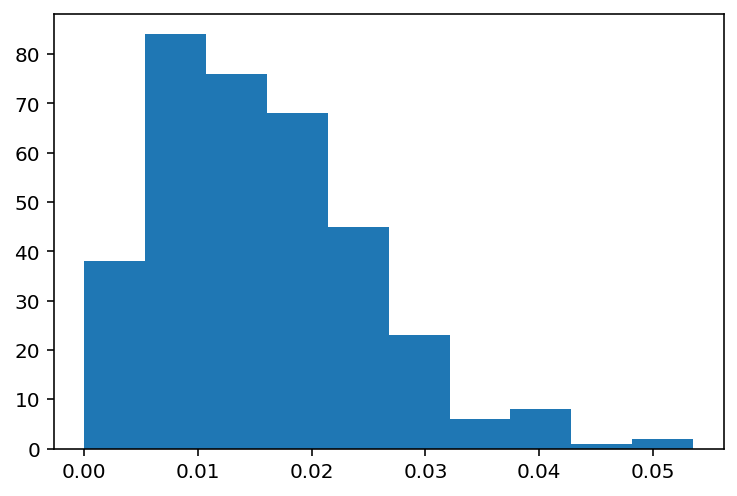

In [89]:
plt.hist(df_last['error_rate'])